# Анализ эффективности каналов привлечения.
 
Нужно определить:
- какие каналы окупаются
- какой из них самый прибыльный с точки зрения прибыли на один юнит.
 
**Какие бизнес выводы можно сделать из данного исследования?**

In [101]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

Подключили нужные библиотеки, сохранили данные, ознакомились с ними

In [102]:
df = pd.read_excel('ltv.xlsx', sheet_name='Данные по каналам')
cost = pd.read_excel('ltv.xlsx', sheet_name='Стоимость привлечения')

df.head()

,Канал привлечения,"LTV, руб."
0,Реклама у блогеров,90
1,Реклама в новостных СМИ,120
2,Реклама в новостных СМИ,240
3,Контекстная реклама,590
4,Контекстная реклама,670


Уберем из таблицы строки с отрицательным LTV и с пропущенными значениями

In [103]:
df_filtered = df[df['LTV, руб.'] >= 0].dropna()
df_filtered

,Канал привлечения,"LTV, руб."
0,Реклама у блогеров,90
1,Реклама в новостных СМИ,120
2,Реклама в новостных СМИ,240
3,Контекстная реклама,590
4,Контекстная реклама,670
...,...,...
1795,Нативная реклама,320
1796,Нативная реклама,480
1797,Нативная реклама,270
1798,Таргетная реклама,350


Построим boxplot, чтобы узнать, есть ли выбросы, и посмотреть на распределение данных

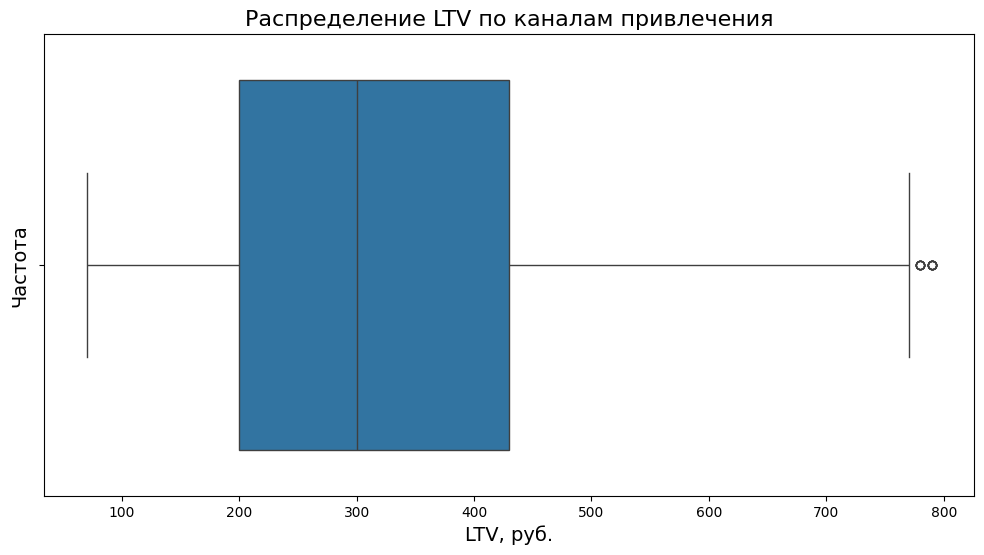

In [104]:
plt.figure(figsize=(12,6))
sns.boxplot(x=df_filtered['LTV, руб.'])

plt.title('Распределение LTV по каналам привлечения', fontsize=16)
plt.xlabel('LTV, руб.', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.show()

Найдем квартили, межквартильный размах и границы, чтобы посмотреть на выбросы

In [105]:
Q1 = df_filtered['LTV, руб.'].quantile(0.25)
Q3 = df_filtered['LTV, руб.'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_filtered[(df_filtered['LTV, руб.'] < lower_bound) | (df_filtered['LTV, руб.'] > upper_bound)]
outliers


,Канал привлечения,"LTV, руб."
339,Контекстная реклама,790
470,Контекстная реклама,780
610,Контекстная реклама,780
734,Контекстная реклама,790
755,Контекстная реклама,780
1070,Контекстная реклама,790
1133,Контекстная реклама,790
1174,Контекстная реклама,780
1238,Контекстная реклама,780
1270,Контекстная реклама,780


Я решила оставить эти выбросы, они не выглядят как ошибка в данных, это могут быть просто богатые клиенты
 
Группируем таблицу по каналам привлечения, вычисляем количество клиентов в каждом канале и считаем сумму LTV по каналам.

In [106]:
clients = df_filtered.groupby(df_filtered['Канал привлечения']).agg(
    count_clients=('LTV, руб.', 'count'),
    ltv=('LTV, руб.', 'mean'),
).reset_index()
clients

,Канал привлечения,count_clients,ltv
0,e-mail рассылки,100,234.800000
1,Контекстная реклама,150,652.333333
2,Нативная реклама,250,393.480000
3,Реклама в новостных СМИ,300,236.400000
4,Реклама у блогеров,700,215.628571
5,Таргетная реклама,300,496.033333


Объединяем таблицы, находим стоимость привлечения одного клиента по каждому каналу, а также считаем прибыль по каналам за 1 клиента как **LTV - CAC** 

In [107]:
df = clients.merge(cost, how='inner', on='Канал привлечения')
df['CAC, руб.'] = round(df['Стоимость привлечения, руб.'] / df['count_clients'])
df['Прибыль, руб.'] = df['ltv'] - df['CAC, руб.']
df

,Канал привлечения,count_clients,ltv,"Стоимость привлечения, руб.","CAC, руб.","Прибыль, руб."
0,e-mail рассылки,100,234.800000,25000,250.0,-15.200000
1,Контекстная реклама,150,652.333333,90000,600.0,52.333333
2,Нативная реклама,250,393.480000,70000,280.0,113.480000
3,Реклама в новостных СМИ,300,236.400000,60000,200.0,36.400000
4,Таргетная реклама,300,496.033333,100000,333.0,163.033333


Переименуем некоторые столбцы, для удобства

In [108]:
df = df.rename(columns={'count_clients': 'Количество клиентов', 'ltv': 'LTV, руб'})
df

,Канал привлечения,Количество клиентов,"LTV, руб","Стоимость привлечения, руб.","CAC, руб.","Прибыль, руб."
0,e-mail рассылки,100,234.800000,25000,250.0,-15.200000
1,Контекстная реклама,150,652.333333,90000,600.0,52.333333
2,Нативная реклама,250,393.480000,70000,280.0,113.480000
3,Реклама в новостных СМИ,300,236.400000,60000,200.0,36.400000
4,Таргетная реклама,300,496.033333,100000,333.0,163.033333


Построим графики для того, чтобы сделать выводы

C:\Users\Karina\AppData\Local\Temp\ipykernel_9472\393561972.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Канал привлечения', y='Прибыль, руб.', palette='viridis')


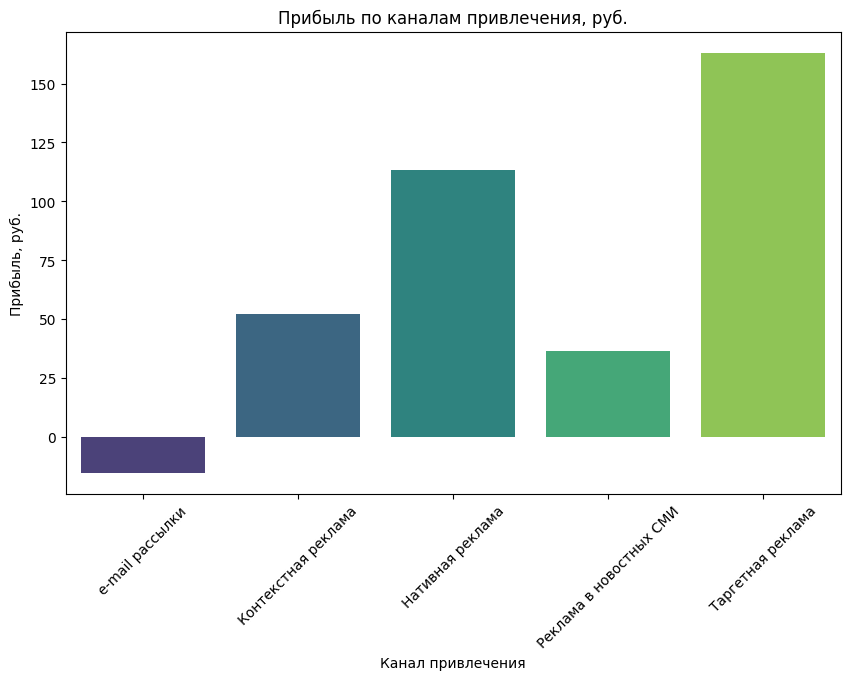

In [109]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Канал привлечения', y='Прибыль, руб.', palette='viridis')
plt.xticks(rotation=45)

plt.xlabel('Канал привлечения')
plt.ylabel('Прибыль, руб.')
plt.title('Прибыль по каналам привлечения, руб.')

plt.show()

Из графика "Прибыль по каналам привлечения" можно сделать вывод, что **наибольшую прибыль принесли клиенты из "Таргетной рекламы", а также из "Нативной рекламы".** Остальные каналы показывают себя значительно хуже. **А канал "E-mail рассылки" вообще оказался убыточным.**

C:\Users\Karina\AppData\Local\Temp\ipykernel_9472\2040127231.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Канал привлечения', y='CAC, руб.', palette='coolwarm')


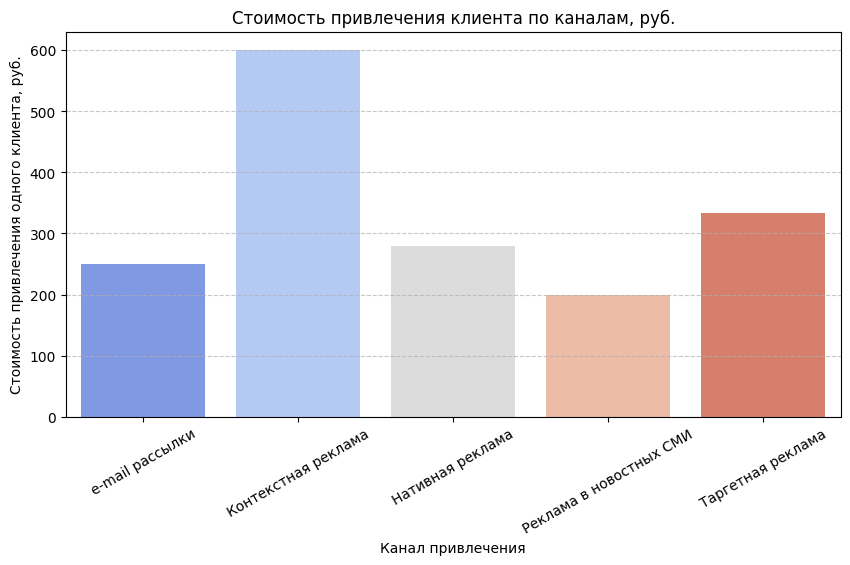

In [110]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='Канал привлечения', y='CAC, руб.', palette='coolwarm')

plt.xlabel('Канал привлечения')
plt.ylabel('Стоимость привлечения одного клиента, руб.')
plt.title('Стоимость привлечения клиента по каналам, руб.')
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Из графика "Стоимость привлечения клиента по каналам" делаем вывод, что **наибольшая цена за клиента у канала "Контекстная реклама", далее идет "Таргетная реклама", а у остальных способов цена за клиента ниже и практически одинаковая.**  

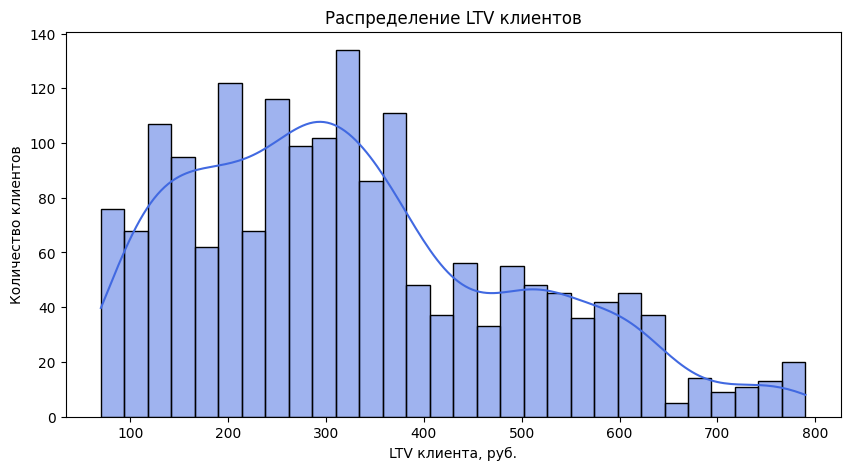

In [111]:
plt.figure(figsize=(10, 5))
sns.histplot(df_filtered['LTV, руб.'], bins=30, kde=True, color="royalblue")

plt.xlabel('LTV клиента, руб.')
plt.ylabel('Количество клиентов')
plt.title('Распределение LTV клиентов')

plt.show()

Из графика "Распределение LTV клиентов" видно, **что большая часть LTV клиентов находится в диапазоне от примерно 140 до 380**. С возрастанием LTV, количество таких клиентов уменьшается. 

C:\Users\Karina\AppData\Local\Temp\ipykernel_9472\1010505483.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Канал привлечения', y=df['LTV, руб'], palette='viridis')


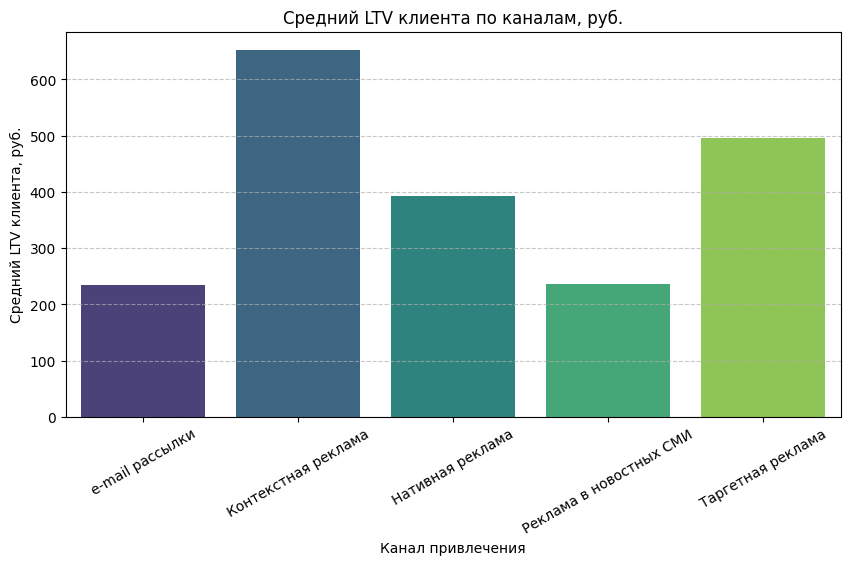

In [112]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='Канал привлечения', y=df['LTV, руб'], palette='viridis')

plt.xlabel('Канал привлечения')
plt.ylabel('Средний LTV клиента, руб.')
plt.title('Средний LTV клиента по каналам, руб.')
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Из графика "Средний LTV клиента по каналам" видно, что **"Контекстная реклама" привлекает клиентов с наибольшим средним LTV. Далее идут "Таргетная" и "Нативная" рекламы, а "E-mail рассылки" и "Реклама в новостных СМИ" показывает приблизительно одинаковый низкий результат.** 

Так как канал "Email рассылки" оказался убыточным, стоит дополнительно его изучить.

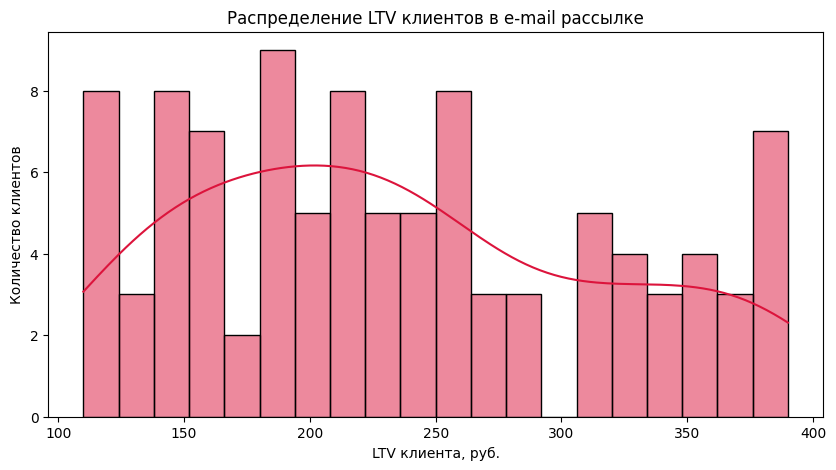

In [113]:
email_clients = df_filtered[df_filtered['Канал привлечения'] == 'e-mail рассылки']

plt.figure(figsize=(10, 5))
sns.histplot(email_clients['LTV, руб.'], bins=20, kde=True, color='crimson')

plt.xlabel('LTV клиента, руб.')
plt.ylabel('Количество клиентов')
plt.title('Распределение LTV клиентов в e-mail рассылке')

plt.show()

Из графика "Распределение LTV клиентов в e-mail рассылке" делаем вывод, что в канале нет аномально прибыльных клиентов. LTV распределен равномерно от 100 до 390. Значит, проблема в самом канале. 

C:\Users\Karina\AppData\Local\Temp\ipykernel_9472\1930960955.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered, x='Канал привлечения', y='LTV, руб.', palette='coolwarm')


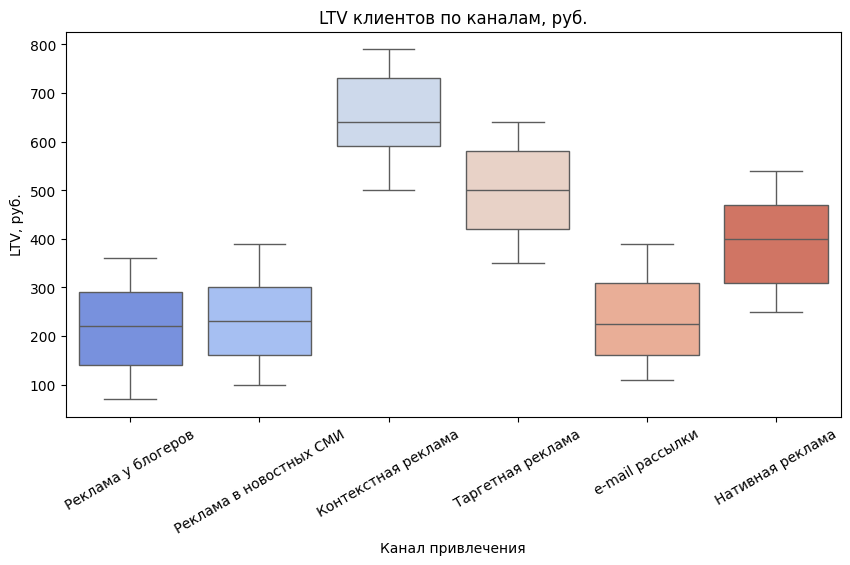

In [114]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_filtered, x='Канал привлечения', y='LTV, руб.', palette='coolwarm')

plt.xticks(rotation=30)
plt.title('LTV клиентов по каналам, руб.')

plt.show()

Boxplot "e-mail рассылки" практически совпадает с boxplot "Реклама в новостных СМИ" и "Реклама у блоггеров", которые являются прибыльными.  

Цена привлечения клиента у "Email рассылки" составляет 250, и является довольно низкой, по сравнению с остальными каналами. **Основной проблемой убыточности канала может являться низкий средний LTV.**

# Общий вывод:
## Прибыльность каналов привлечения:
Из графика "Прибыль по каналам привлечения" видно, что "Таргетная реклама" и "Нативная реклама" принесли **наибольшую прибыль**, что делает их наиболее эффективными каналами. Остальные каналы не показывают таких высоких результатов, а канал "E-mail рассылки" оказался **убыточным**.

## Стоимость привлечения клиентов:
График "Стоимость привлечения клиента по каналам" показывает, что "Контекстная реклама" имеет **наибольшую стоимость за клиента**, за ней следует "Таргетная реклама". Для других каналов цена за клиента **значительно ниже** и примерно одинаковая.

## Распределение LTV:
Согласно графику "Распределение LTV клиентов", основная часть клиентов имеет **LTV в диапазоне от 150 до 380 руб**. С увеличением LTV количество таких клиентов уменьшается.

## Средний LTV по каналам:
Из графика "Средний LTV клиента по каналам" видно, что "Контекстная реклама" привлекает клиентов с **наибольшим средним LTV**, за ней идут "Таргетная" и "Нативная реклама". Каналы "E-mail рассылки" и "Реклама в новостных СМИ" показывают схожие результаты по среднему LTV, но они значительно ниже, чем у более прибыльных каналов.

## Проблемы канала "E-mail рассылка":
Несмотря на то что стоимость привлечения клиента у "E-mail рассылки" составляет 250 руб., что является довольно низким показателем, канал оказался убыточным из-за **низкого LTV**. Это может указывать на **недостаточную вовлеченность клиентов и низкую эффективность взаимодействия с ними**.

## Что можно предпринять, чтобы канал "Email рассылки" перестал быть убыточным:
- Удешевить канал
- Изменить аудиторию рассылки
- Проанализировать и оптимизировать контент писем и вовлеченность
 
Если оптимизация не поможет, стоит **отключить этот канал и перераспределить его бюджет на более эффективные каналы, такие как "Таргетная реклама" и "Нативная реклама".** 
